# Isochrone Map of Train Stations in Tokyo

I have made an isochrone map of hotspots in Tokyo, Japan. This map shows a 15 minute walk-time radius around the train stations in Tokyo.

Since this code uses latitude and longitude for the isochrone maps, I needed to find the lat/long for the train stations. I used wikipedia to get the list of the 648 train stations in Tokyo and used the Geocode Google sheets extension by Awesome Table to get the lat/long for each station.

Here is the tableau of the isochrone maps showing the train stations and hotspots in Tokyo.

https://public.tableau.com/app/profile/brendan.sakihara1778/viz/TrainStationandHotspotsinTokyoMap/Dashboard1

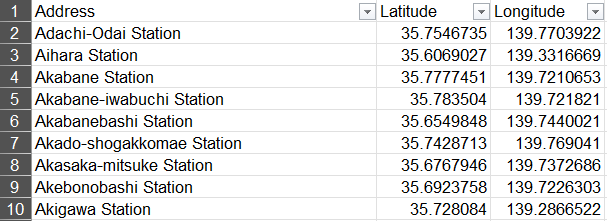

In [9]:
import geopandas as gp
import pandas as pd
from shapely.geometry import Polygon
from routingpy.routers import MapboxOSRM
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import fiona
import osmnx as ox

In [11]:
df = pd.read_excel('Tokyo Train Stations.xlsx', sheet_name= 'Stations')

In [12]:
df.head()

,Address,Latitude,Longitude
0,Adachi-Odai Station,35.754674,139.770392
1,Aihara Station,35.606903,139.331667
2,Akabane Station,35.777745,139.721065
3,Akabane-iwabuchi Station,35.783504,139.721821
4,Akabanebashi Station,35.654985,139.744002


In [13]:
# Code from Kyle Walker https://walker-data.com/posts/python-isochrones/

def mb_isochrone(df, time = [], profile = "walking"):
    coordinates = df[['Longitude', 'Latitude']].values.tolist()

    

      # Build a list of shapes
    isochrone_shapes = []

    if type(time) is not list:
        time = [time]

    # Use minutes as input, but the API requires seconds
    time_seconds = [60 * x for x in time]

    # Given the way that routingpy works, we need to iterate through the list of 
    # coordinate pairs, then iterate through the object returned and extract the 
    # isochrone geometries.  
    for c in coordinates:
        iso_request = mb.isochrones(locations = c, profile = profile,
                                    intervals = time_seconds, polygons = "true")

        for i in iso_request:
            iso_geom = Polygon(i.geometry[0])
            isochrone_shapes.append(iso_geom)

    # Here, we re-build the dataset but with isochrone geometries
    df_values = df.drop(columns = ['Longitude', 'Latitude'])

    time_col = time * len(df_values)

    # We'll need to repeat the dataframe to account for multiple time intervals
    df_values_rep = pd.DataFrame(np.repeat(df_values.values, len(time_seconds), axis = 0))
    df_values_rep.columns = df_values.columns

    isochrone_gdf = gp.GeoDataFrame(
        data = df_values_rep,
        geometry = isochrone_shapes,
        crs = 4326
    )

    isochrone_gdf['time'] = time_col

    # We are sorting the dataframe in descending order of time to improve visualization
    # (the smallest isochrones should go on top, which means they are plotted last)
    isochrone_gdf = isochrone_gdf.sort_values('time', ascending = False)



    return(isochrone_gdf)

In [14]:
df_geo = gp.GeoDataFrame(df, geometry = gp.points_from_xy(df['Longitude'], df['Latitude']))
df_geo

,Address,Latitude,Longitude,geometry
0,Adachi-Odai Station,35.754674,139.770392,POINT (139.77039 35.75467)
1,Aihara Station,35.606903,139.331667,POINT (139.33167 35.60690)
2,Akabane Station,35.777745,139.721065,POINT (139.72107 35.77775)
3,Akabane-iwabuchi Station,35.783504,139.721821,POINT (139.72182 35.78350)
4,Akabanebashi Station,35.654985,139.744002,POINT (139.74400 35.65498)
...,...,...,...,...
643,Yurakucho Station,35.675013,139.763020,POINT (139.76302 35.67501)
644,Yushima Station (Tokyo),35.707180,139.769941,POINT (139.76994 35.70718)
645,Yutenji Station,35.637442,139.690948,POINT (139.69095 35.63744)
646,Zoshigaya Station,35.720199,139.714844,POINT (139.71484 35.72020)


In [15]:
library_isos = mb_isochrone(df_geo, time = 15, 
                            profile = "walking")


m = library_isos.explore()
m = df_geo['geometry'].explore(m=m,marker_kwds={'radius': 5, 'color': 'black'})
m = df_geo['geometry'].explore(m=m,marker_kwds={'radius': 5, 'color': 'white'})

In [16]:
m

In [17]:
library_isos.to_file(r'C:/Users/Brendan/Desktop/DA/Projects/Japan Train Station Maps/Isochrones/Tokyo Train Stations Iso.shp', driver='ESRI Shapefile')